# NBA Point Spread Regressor Experiments

## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_point_spead_reg as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

Autosaving every 60 seconds


### Utils functions

In [7]:
def filter_from(items, cond):
    return list(filter(cond, items)) 

In [8]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [9]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [10]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [11]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [12]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [13]:
def plot_results(experiment_name, results, figsize=(10,6)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    #     a = sns.pointplot(data=results_df,
    #               kind="point", x="season_test", y="rmse", hue="model"
    #               )
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="mae", hue="model", style="model",
        markers=True, dashes=False
    )
    a.set_title(
        f"{experiment_name}-mae")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [14]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [15]:
reg_metrics = ['mae', 'mse', 'rmse']

def print_prettier_exp_results(exp_name, metric='mae', filter_val=None):
    second_metric = 'rmse' if metric == 'mae' else 'mae'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model == filter_val)
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=True)

## Load Dataset

In [16]:
season_games = sg.load_season_games_dataset()

## Dataset


In [17]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [18]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [19]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 405)
0
(9461, 405)


## Experiments

### Setup

In [20]:
exp_prefix = "reg_"
## exp_group_name = "reg_experiments"
exp_group_name = "reg_experiments"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_POINT_SPREAD"
exp_X_columns = model_config.X_COLS_NO_HIGH_CORR
exp_y_columns = model_config.Y_REG_COL

models = utils_exp.get_reg_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Experiment using 1 season

In [21]:
experiment_name = f"{exp_prefix}1_season"

In [22]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_1_season
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
3  reg_1_season    RF   9.852666  0.277389  12.545130  0.356161
1  reg_1_season   KNN   9.923061  0.217321  12.618358  0.283024
2  reg_1_season   SVM  10.088597  0.214758  12.838252  0.306322
0  reg_1_season    LR  10.250696  0.286978  13.025696  0.400877
4  reg_1_season   LGB  10.350949  0.261646  13.170608  0.328641
5  reg_1_season   XGB  10.705118  0.311235  13.608599  0.434667

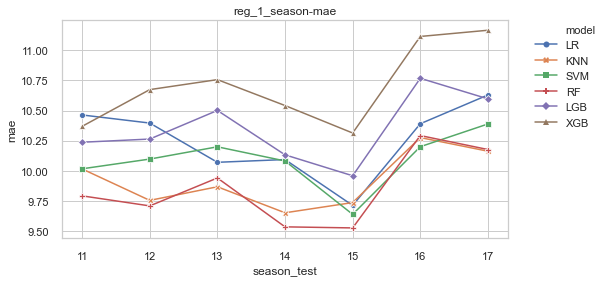

In [23]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [24]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1213           11                972
1            11                 972           12               1209
2            12                1209           13               1213
3            13                1213           14               1213
4            14                1213           15               1213
5            15                1213           16               1214
6            16                1214           17               1214

### Experiment using StandardScaler

In [25]:
experiment_name = f"{exp_prefix}scaled_data"

In [26]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_scaled_data
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
9   reg_scaled_data    RF   9.852550  0.276802  12.544431  0.355586
7   reg_scaled_data   KNN  10.014366  0.202305  12.744109  0.273942
6   reg_scaled_data    LR  10.209608  0.274686  12.977370  0.391315
8   reg_scaled_data   SVM  10.249170  0.255993  13.023220  0.342042
10  reg_scaled_data   LGB  10.355848  0.243795  13.159138  0.317148
11  reg_scaled_data   XGB  10.705455  0.309103  13.611206  0.431404

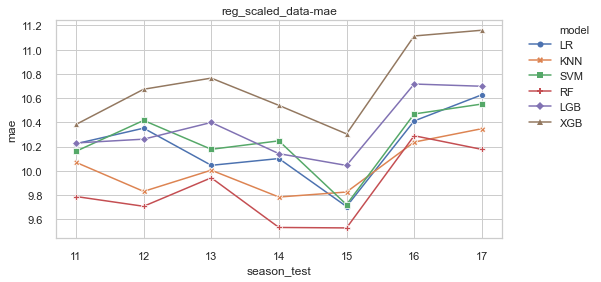

In [27]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


In [28]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1213           11                972
1            11                 972           12               1209
2            12                1209           13               1213
3            13                1213           14               1213
4            14                1213           15               1213
5            15                1213           16               1214
6            16                1214           17               1214

### Experiment using MinMaxScaler

In [29]:
experiment_name = f"{exp_prefix}minmax_data"

In [30]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_minmax_data
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
14  reg_minmax_data   SVM   9.791417  0.245853  12.468283  0.329131
15  reg_minmax_data    RF   9.852226  0.276478  12.544850  0.355101
13  reg_minmax_data   KNN   9.991643  0.216920  12.686479  0.304776
12  reg_minmax_data    LR  10.217243  0.266990  12.994699  0.381158
16  reg_minmax_data   LGB  10.402559  0.272068  13.196310  0.353474
17  reg_minmax_data   XGB  10.704996  0.312558  13.611400  0.437353

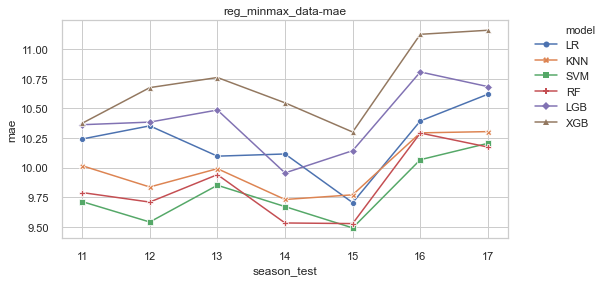

In [31]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [32]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1213           11                972
1            11                 972           12               1209
2            12                1209           13               1213
3            13                1213           14               1213
4            14                1213           15               1213
5            15                1213           16               1214
6            16                1214           17               1214

### Experiment: train: 2s; test: 1s

In [33]:
experiment_name = f"{exp_prefix}2_seasons"

In [34]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment reg_2_seasons
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
21  reg_2_seasons    RF   9.793544  0.296918  12.482894  0.367710
20  reg_2_seasons   SVM   9.837152  0.233300  12.530506  0.311140
18  reg_2_seasons    LR   9.885877  0.271949  12.596751  0.353302
19  reg_2_seasons   KNN   9.899943  0.228055  12.597284  0.316411
22  reg_2_seasons   LGB  10.188386  0.267671  12.998478  0.337525
23  reg_2_seasons   XGB  10.716321  0.366097  13.582992  0.410318

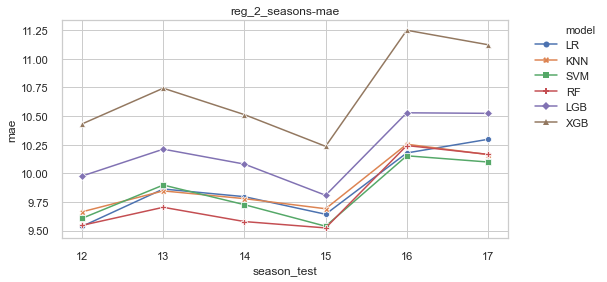

In [35]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [36]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0         10-11                2185           12               1209
1         11-12                2181           13               1213
2         12-13                2422           14               1213
3         13-14                2426           15               1213
4         14-15                2426           16               1214
5         15-16                2427           17               1214

### Experiment: train: 3s; test: 1s

In [37]:
experiment_name = f"{exp_prefix}3_seasons"

In [38]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3_seasons
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
27  reg_3_seasons    RF   9.809598  0.314380  12.440092  0.411442
26  reg_3_seasons   SVM   9.824550  0.249880  12.479287  0.351153
24  reg_3_seasons    LR   9.831022  0.231023  12.487218  0.324883
25  reg_3_seasons   KNN   9.943358  0.245539  12.659153  0.339628
28  reg_3_seasons   LGB  10.190443  0.331594  12.904817  0.373543
29  reg_3_seasons   XGB  10.617477  0.335267  13.478740  0.386240

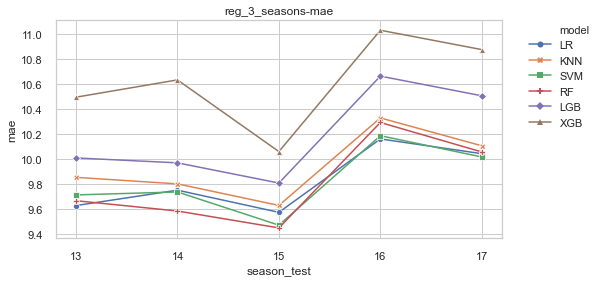

In [39]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [40]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0      10-11-12                3394           13               1213
1      11-12-13                3394           14               1213
2      12-13-14                3635           15               1213
3      13-14-15                3639           16               1214
4      14-15-16                3640           17               1214

### Experiment remove last 2q ; train: 2q ; test: 2q

In [41]:
experiment_name = f"{exp_prefix}2q_2q_r2q"

In [42]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.75, 1.0])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q_r2q
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
31  reg_2q_2q_r2q   KNN  10.023826  0.314332  12.674650  0.386685
33  reg_2q_2q_r2q    RF  10.034111  0.291801  12.680044  0.376266
32  reg_2q_2q_r2q   SVM  10.363708  0.233560  13.145196  0.377824
34  reg_2q_2q_r2q   LGB  10.536953  0.343885  13.302349  0.433187
30  reg_2q_2q_r2q    LR  10.968836  0.322448  13.818984  0.426925
35  reg_2q_2q_r2q   XGB  11.044959  0.500439  13.854157  0.591536

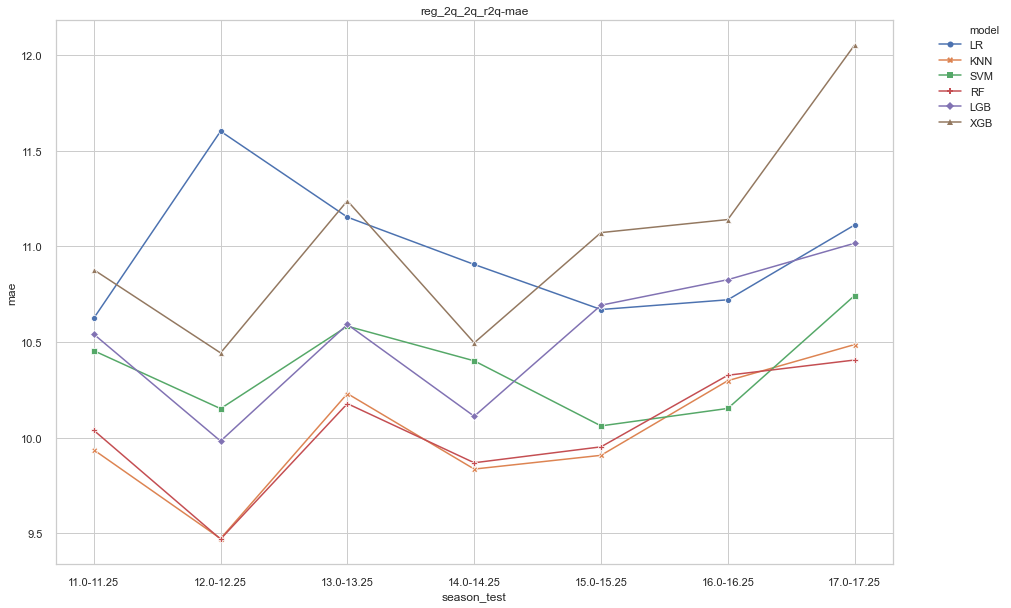

In [43]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [44]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0    10.0-10.25                 606   11.0-11.25                486
1    11.0-11.25                 486   12.0-12.25                604
2    12.0-12.25                 604   13.0-13.25                606
3    13.0-13.25                 606   14.0-14.25                606
4    14.0-14.25                 606   15.0-15.25                606
5    15.0-15.25                 606   16.0-16.25                607
6    16.0-16.25                 607   17.0-17.25                607

### Experiment remove first 2q ;train: 2q ; test: 2q

In [45]:
experiment_name = f"{exp_prefix}2q_2q_r2q"

In [46]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q_r2q
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
31  reg_2q_2q_r2q   KNN   9.825688  0.320442  12.517244  0.346772
33  reg_2q_2q_r2q    RF   9.847229  0.301536  12.623723  0.343590
34  reg_2q_2q_r2q   LGB  10.420901  0.297140  13.231462  0.353595
32  reg_2q_2q_r2q   SVM  10.597010  0.523291  13.445252  0.569299
35  reg_2q_2q_r2q   XGB  11.116552  0.538354  14.173557  0.625641
30  reg_2q_2q_r2q    LR  11.437010  0.875705  14.446536  1.149232

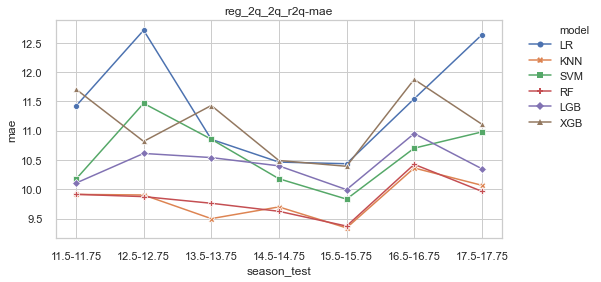

In [47]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [48]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0    10.5-10.75                 607   11.5-11.75                486
1    11.5-11.75                 486   12.5-12.75                605
2    12.5-12.75                 605   13.5-13.75                607
3    13.5-13.75                 607   14.5-14.75                607
4    14.5-14.75                 607   15.5-15.75                607
5    15.5-15.75                 607   16.5-16.75                607
6    16.5-16.75                 607   17.5-17.75                607

### Experiment train: remove last 1q ; 3q ; test: 1q ; step: 3q

In [49]:
experiment_name = f"{exp_prefix}3q_1q_r1q_s3q"

In [50]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, remove_quarters=[1.0], skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q_r1q_s3q
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
39  reg_3q_1q_r1q_s3q    RF   9.874930  0.192801  12.487384  0.259262
37  reg_3q_1q_r1q_s3q   KNN  10.040590  0.252768  12.643597  0.356456
38  reg_3q_1q_r1q_s3q   SVM  10.072694  0.366429  12.812899  0.410267
36  reg_3q_1q_r1q_s3q    LR  10.201644  0.189298  12.958156  0.199022
40  reg_3q_1q_r1q_s3q   LGB  10.510101  0.331129  13.269972  0.336092
41  reg_3q_1q_r1q_s3q   XGB  11.056933  0.435036  13.832889  0.543967

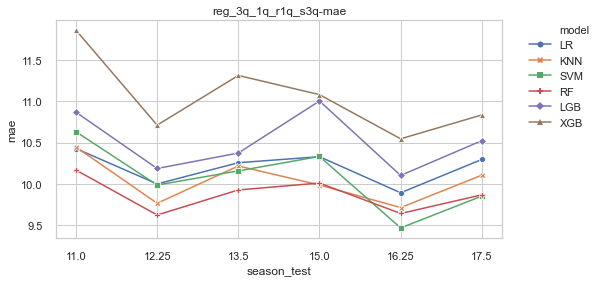

In [51]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [52]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.0-10.25-10.5                 909         11.0                243
1  11.25-11.5-12.0                 788        12.25                302
2  12.5-13.0-13.25                 908         13.5                303
3  14.0-14.25-14.5                 909         15.0                303
4  15.25-15.5-16.0                 909        16.25                304
5  16.5-17.0-17.25                 910         17.5                303

### Experiment train: 3q ; test: 1q ; step: 3q

In [53]:
experiment_name = f"{exp_prefix}3q_1q_3s"

In [54]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q_3s
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
45  reg_3q_1q_3s    RF   9.734348  0.406941  12.451689  0.455445
43  reg_3q_1q_3s   KNN   9.774333  0.364695  12.489675  0.433355
46  reg_3q_1q_3s   LGB  10.255482  0.367910  13.122157  0.373339
44  reg_3q_1q_3s   SVM  10.290000  0.506427  13.086640  0.613462
42  reg_3q_1q_3s    LR  10.364829  0.501007  13.250977  0.672293
47  reg_3q_1q_3s   XGB  10.754352  0.385403  13.642352  0.503133

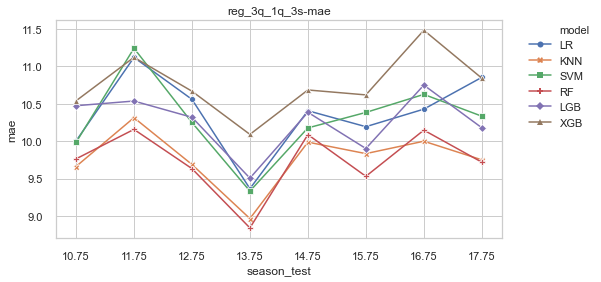

In [55]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [56]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.0-10.25-10.5                 909        10.75                304
1  11.0-11.25-11.5                 729        11.75                243
2  12.0-12.25-12.5                 906        12.75                303
3  13.0-13.25-13.5                 909        13.75                304
4  14.0-14.25-14.5                 909        14.75                304
5  15.0-15.25-15.5                 909        15.75                304
6  16.0-16.25-16.5                 910        16.75                304
7  17.0-17.25-17.5                 910        17.75                304

### Experiment train: 4q ; test: 2q

In [57]:
experiment_name = f"{exp_prefix}4q_2q"

In [58]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
51  reg_4q_2q    RF   9.839121  0.325046  12.518948  0.362607
49  reg_4q_2q   KNN   9.904385  0.278312  12.603532  0.335554
50  reg_4q_2q   SVM  10.023194  0.330795  12.756573  0.379459
48  reg_4q_2q    LR  10.141719  0.370489  12.916234  0.479911
52  reg_4q_2q   LGB  10.343736  0.305484  13.135632  0.392131
53  reg_4q_2q   XGB  10.750351  0.362005  13.621780  0.444484

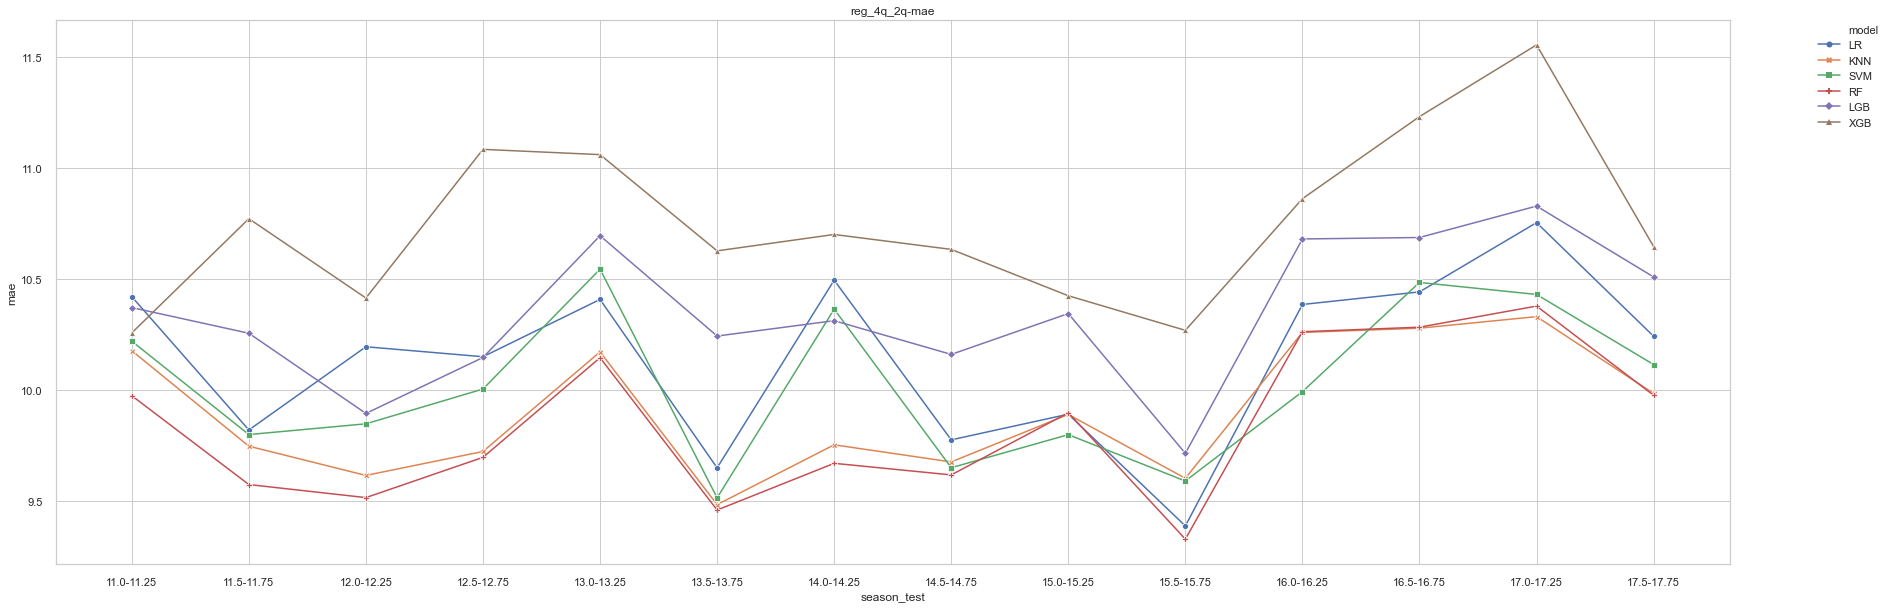

In [59]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30,10))

In [60]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0   10.0-10.25-10.5-10.75                1213   11.0-11.25                486
1   10.5-10.75-11.0-11.25                1093   11.5-11.75                486
2   11.0-11.25-11.5-11.75                 972   12.0-12.25                604
3   11.5-11.75-12.0-12.25                1090   12.5-12.75                605
4   12.0-12.25-12.5-12.75                1209   13.0-13.25                606
5   12.5-12.75-13.0-13.25                1211   13.5-13.75                607
6   13.0-13.25-13.5-13.75                1213   14.0-14.25                606
7   13.5-13.75-14.0-14.25                1213   14.5-14.75                607
8   14.0-14.25-14.5-14.75                1213   15.0-15.25                606
9   14.5-14.75-15.0-15.25                1213   15.5-15.75                607
10  15.0-15.25-15.5-15.75                1213   16.0-16.25                607
11  15.5-15.75-16.0-16.25                1214   16.5-16.75                607
12  16.0-16.25-16.5-16.75                1214   17.0-17.25                607
13  16.5-16.75-17.0-17.25                1214   17.5-17.75                607

### Experiment remove first 2q ; train: 4q ; test: 2q

In [61]:
experiment_name = f"{exp_prefix}4q_2q_r2q"

In [62]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q_r2q
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
57  reg_4q_2q_r2q    RF   9.701156  0.427056  12.423401  0.484943
55  reg_4q_2q_r2q   KNN   9.772899  0.317131  12.542970  0.377145
56  reg_4q_2q_r2q   SVM   9.914536  0.368497  12.654822  0.435775
54  reg_4q_2q_r2q    LR  10.088787  0.469919  12.848267  0.559980
58  reg_4q_2q_r2q   LGB  10.142932  0.477778  12.923587  0.492458
59  reg_4q_2q_r2q   XGB  10.750917  0.511640  13.744422  0.635511

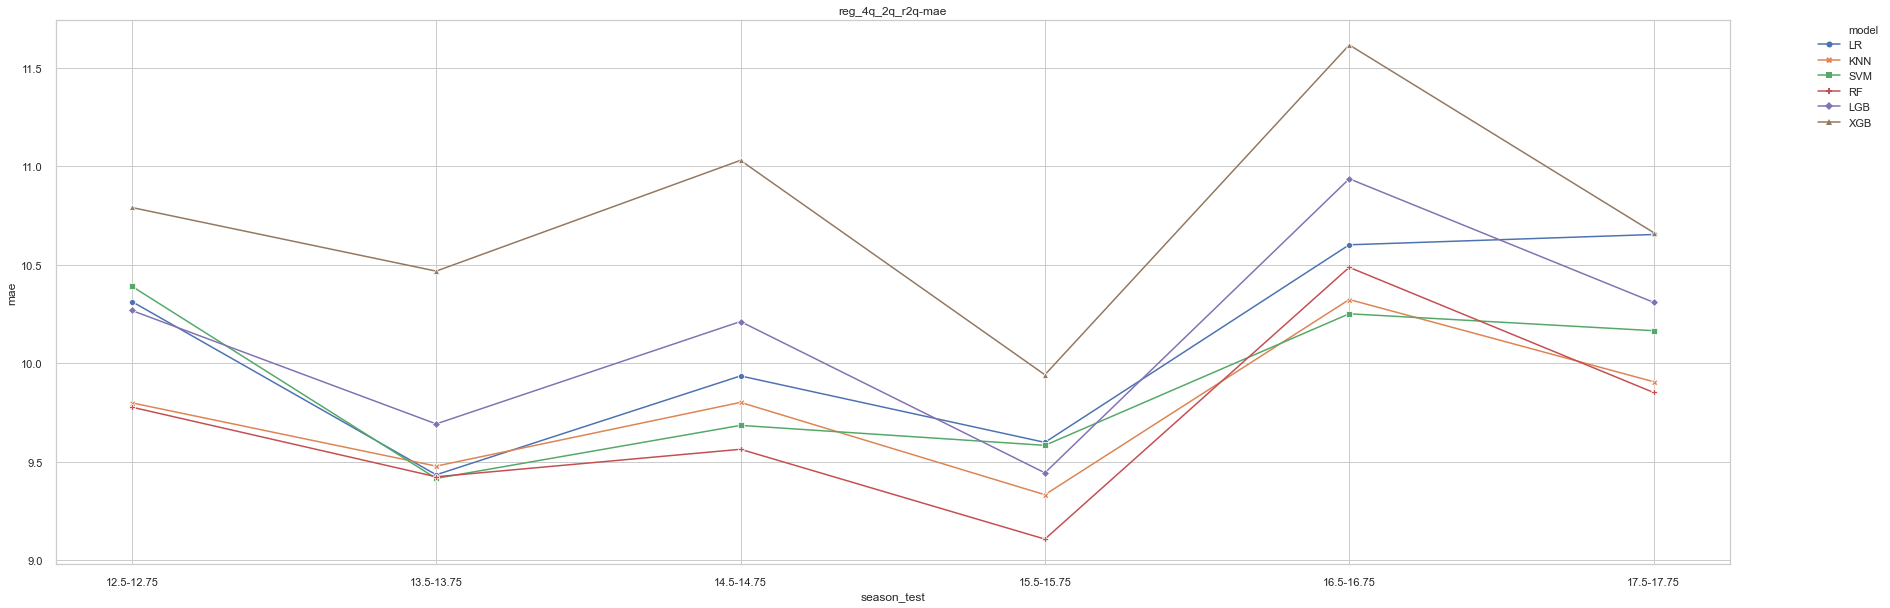

In [63]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30,10))

In [64]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.5-10.75-11.5-11.75                1093   12.5-12.75                605
1  11.5-11.75-12.5-12.75                1091   13.5-13.75                607
2  12.5-12.75-13.5-13.75                1212   14.5-14.75                607
3  13.5-13.75-14.5-14.75                1214   15.5-15.75                607
4  14.5-14.75-15.5-15.75                1214   16.5-16.75                607
5  15.5-15.75-16.5-16.75                1214   17.5-17.75                607

### Experiment remove first 2q ; train: 4q ; test: 2q

In [65]:
experiment_name = f"{exp_prefix}4q_2q_r2q"

In [66]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q_r2q
Done


exp_name model   mae_mean   mae_std  rmse_mean  rmse_std
57  reg_4q_2q_r2q    RF   9.701156  0.427056  12.423401  0.484943
55  reg_4q_2q_r2q   KNN   9.772899  0.317131  12.542970  0.377145
56  reg_4q_2q_r2q   SVM   9.914536  0.368497  12.654822  0.435775
54  reg_4q_2q_r2q    LR  10.088787  0.469919  12.848267  0.559980
58  reg_4q_2q_r2q   LGB  10.142932  0.477778  12.923587  0.492458
59  reg_4q_2q_r2q   XGB  10.750917  0.511640  13.744422  0.635511

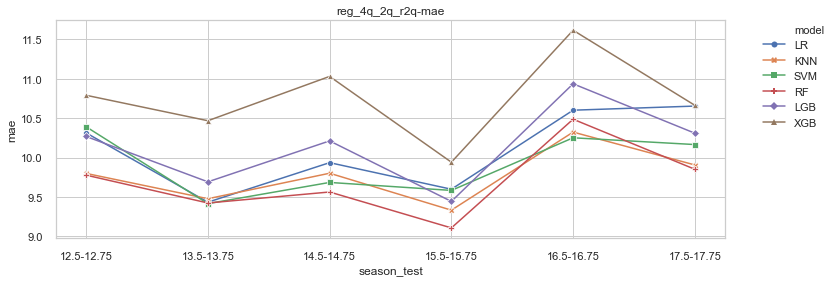

In [67]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(12,4))

In [68]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.5-10.75-11.5-11.75                1093   12.5-12.75                605
1  11.5-11.75-12.5-12.75                1091   13.5-13.75                607
2  12.5-12.75-13.5-13.75                1212   14.5-14.75                607
3  13.5-13.75-14.5-14.75                1214   15.5-15.75                607
4  14.5-14.75-15.5-15.75                1214   16.5-16.75                607
5  15.5-15.75-16.5-16.75                1214   17.5-17.75                607

### Experiments comparison

In [69]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)
utils.serialize_object(f'result_totals_{exp_group_name}', results_total)

In [70]:
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = utils.deserialize_object(exp_group_name, [])
exp_df = get_results_df()

In [71]:
ba_df = exp_df[~exp_df.exp_name.isin(['reg_minmax_data', 'reg_scaled_data'])][['exp_name', 'model',
       'mae_mean', 'mae_std', 'rmse_mean', 'rmse_std']]

In [72]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [73]:
ba_df.sort_values(
    by=["mae_mean"]
    , ascending=True)[:6].reset_index().drop(labels=["index"], axis=1)

exp_name model  mae_mean   mae_std  rmse_mean  rmse_std
0  reg_4q_2q_r2q    RF  9.701156  0.427056  12.423401  0.484943
1   reg_3q_1q_3s    RF  9.734348  0.406941  12.451689  0.455445
2  reg_4q_2q_r2q   KNN  9.772899  0.317131  12.542970  0.377145
3   reg_3q_1q_3s   KNN  9.774333  0.364695  12.489675  0.433355
4  reg_2_seasons    RF  9.793544  0.296918  12.482894  0.367710
5  reg_3_seasons    RF  9.809598  0.314380  12.440092  0.411442

### Plot experiment results

#### MAE

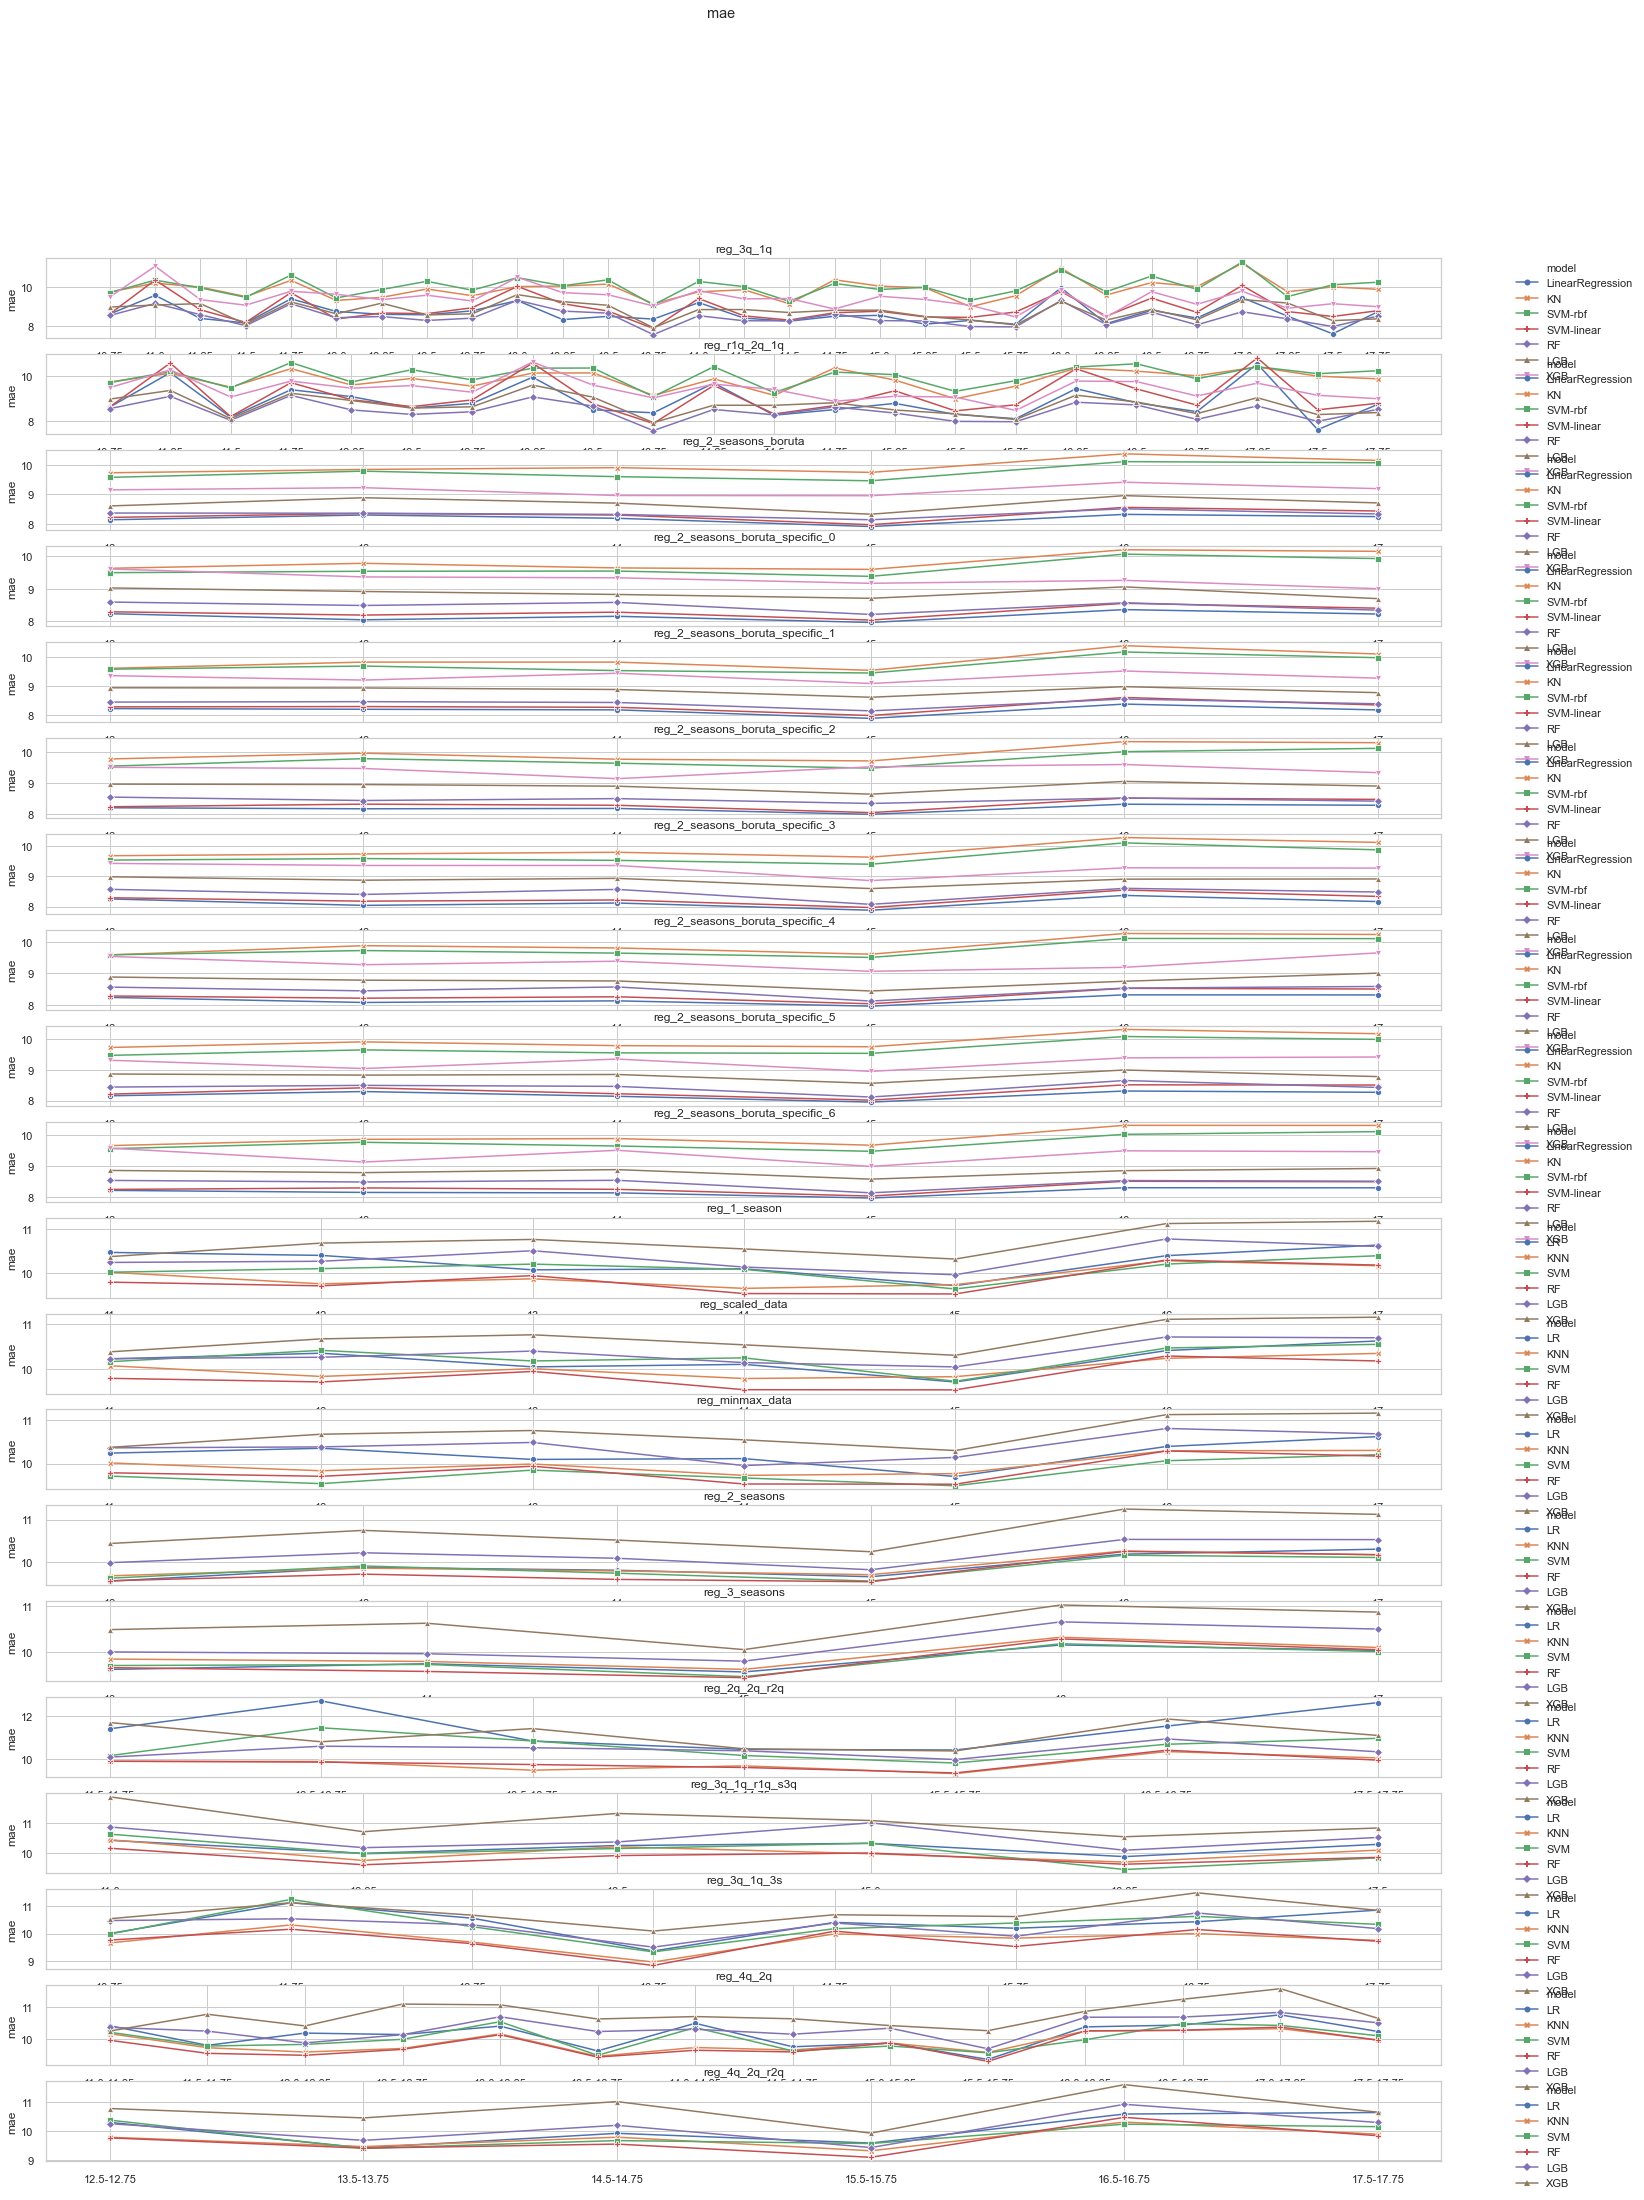

In [74]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mae",
    figsize=(25, 35),
    use_pointplot=True
)

#### MSE

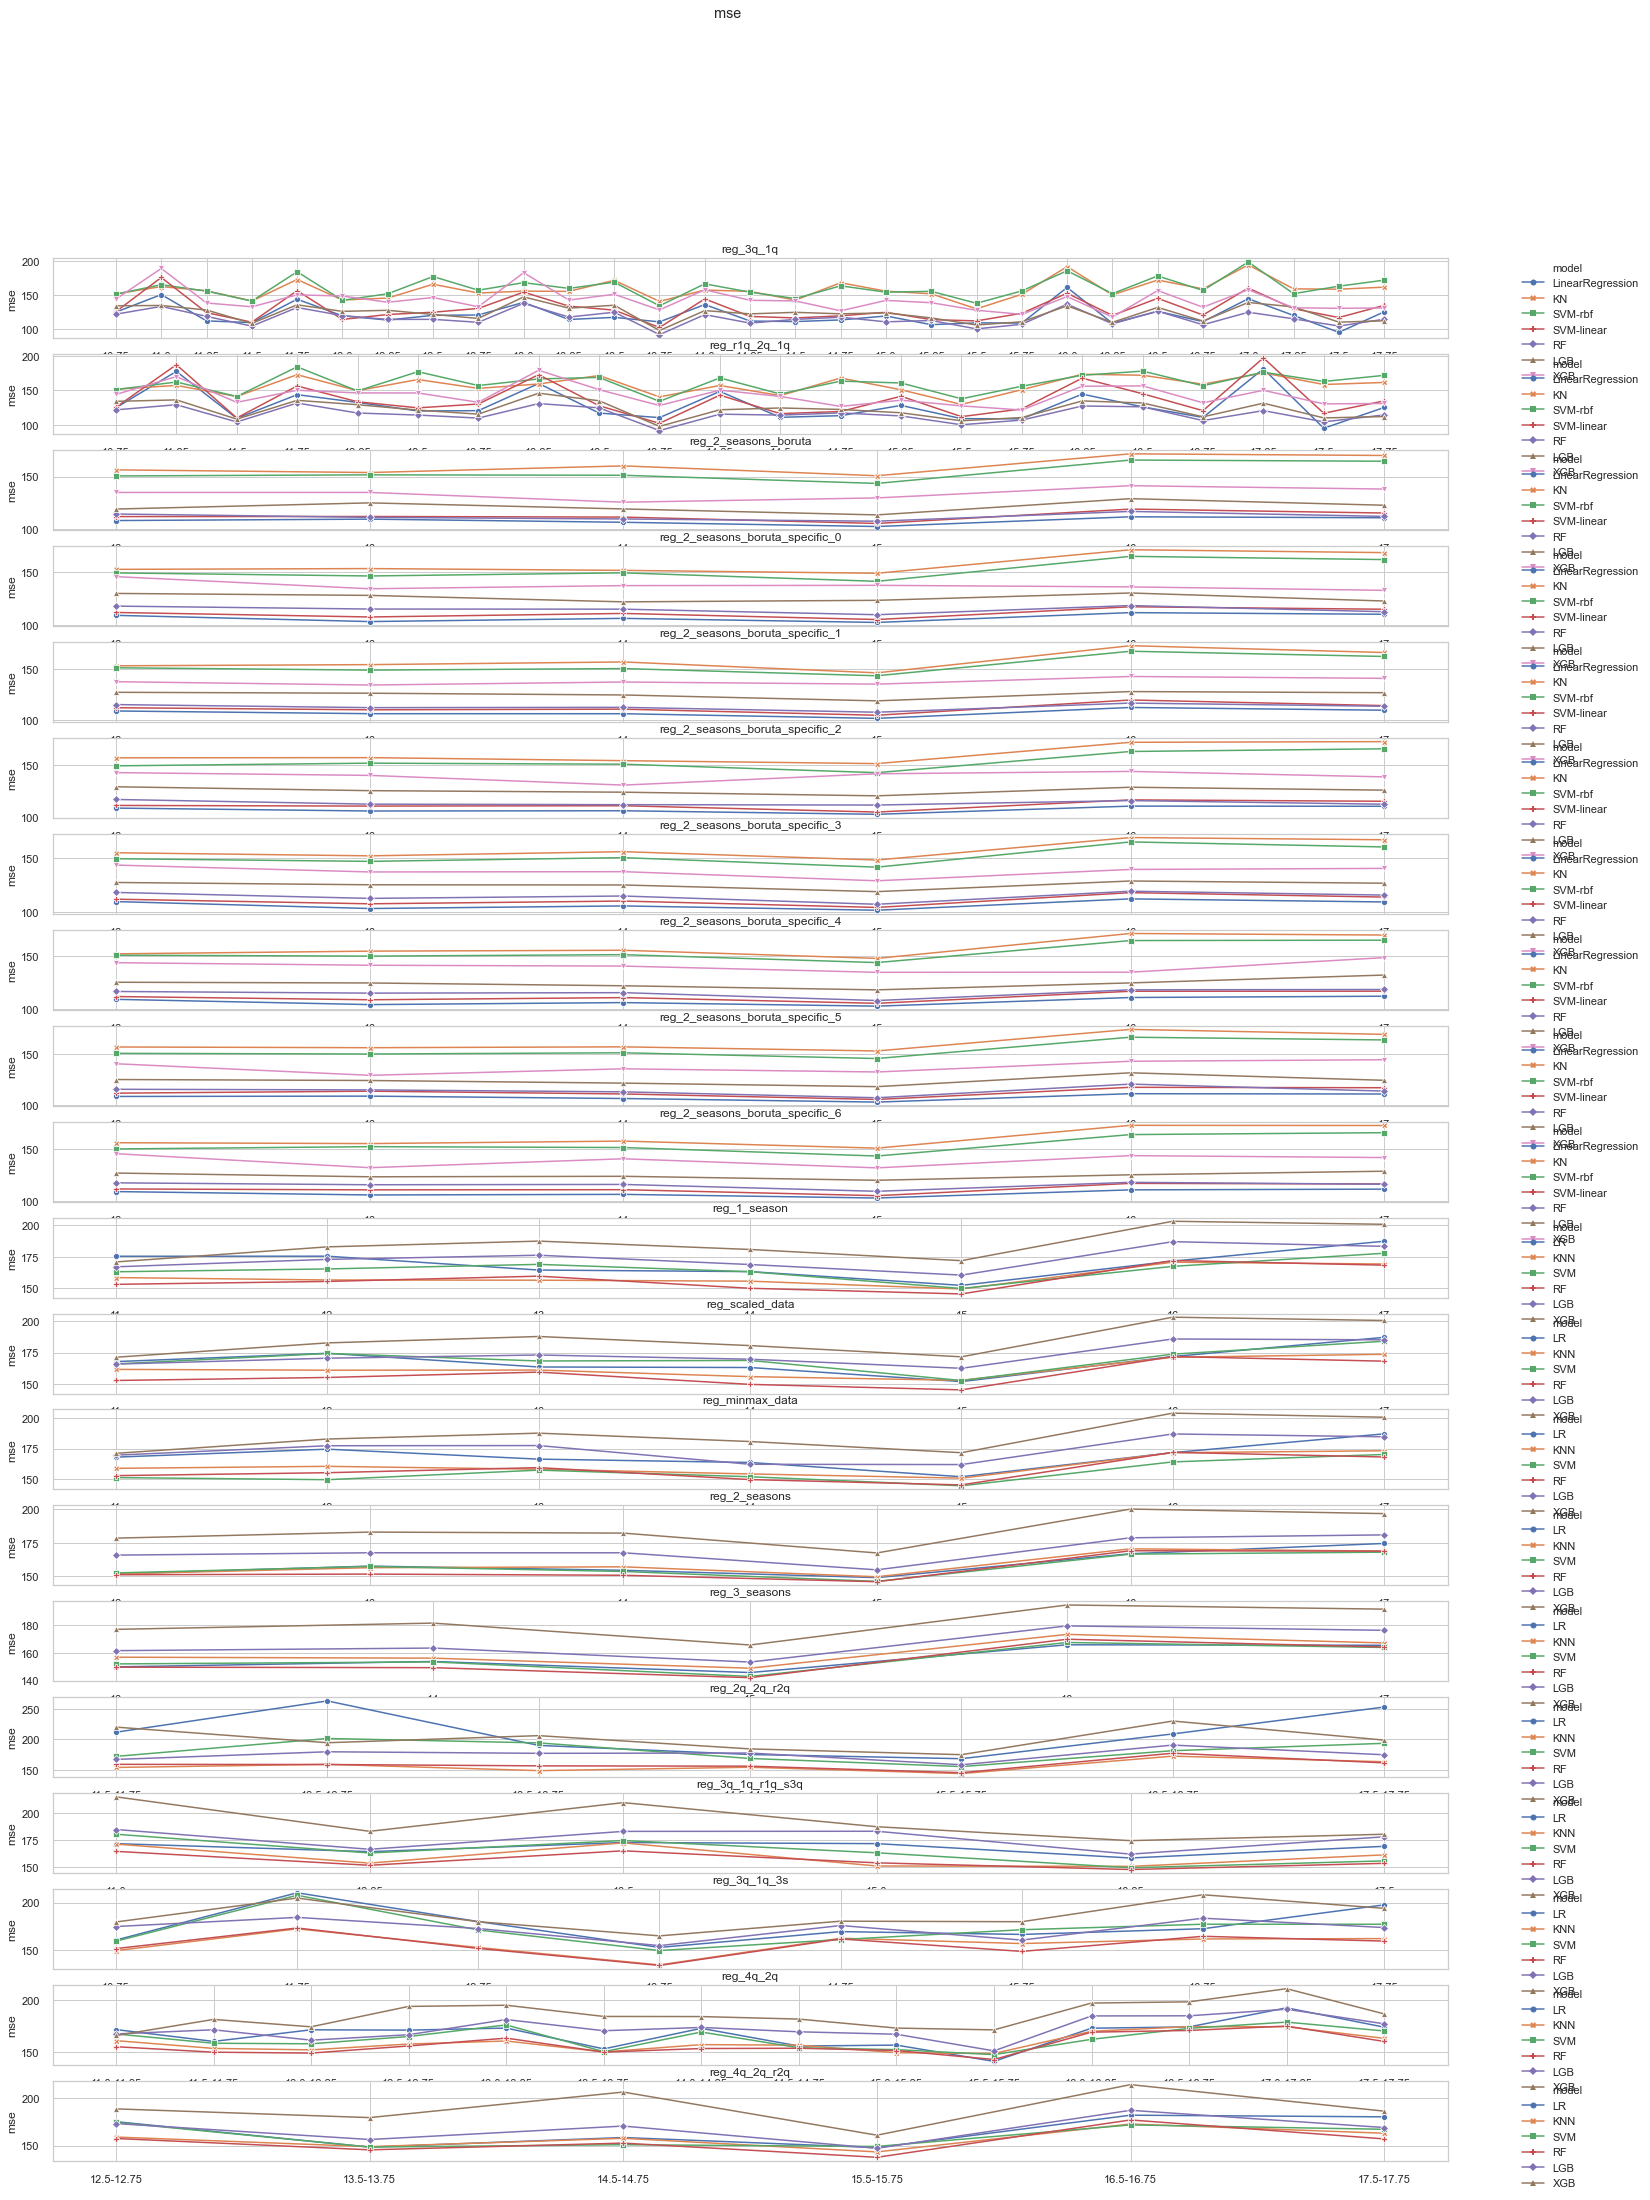

In [75]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mse",
    figsize=(25, 35),
    use_pointplot=True
)

#### RMSE

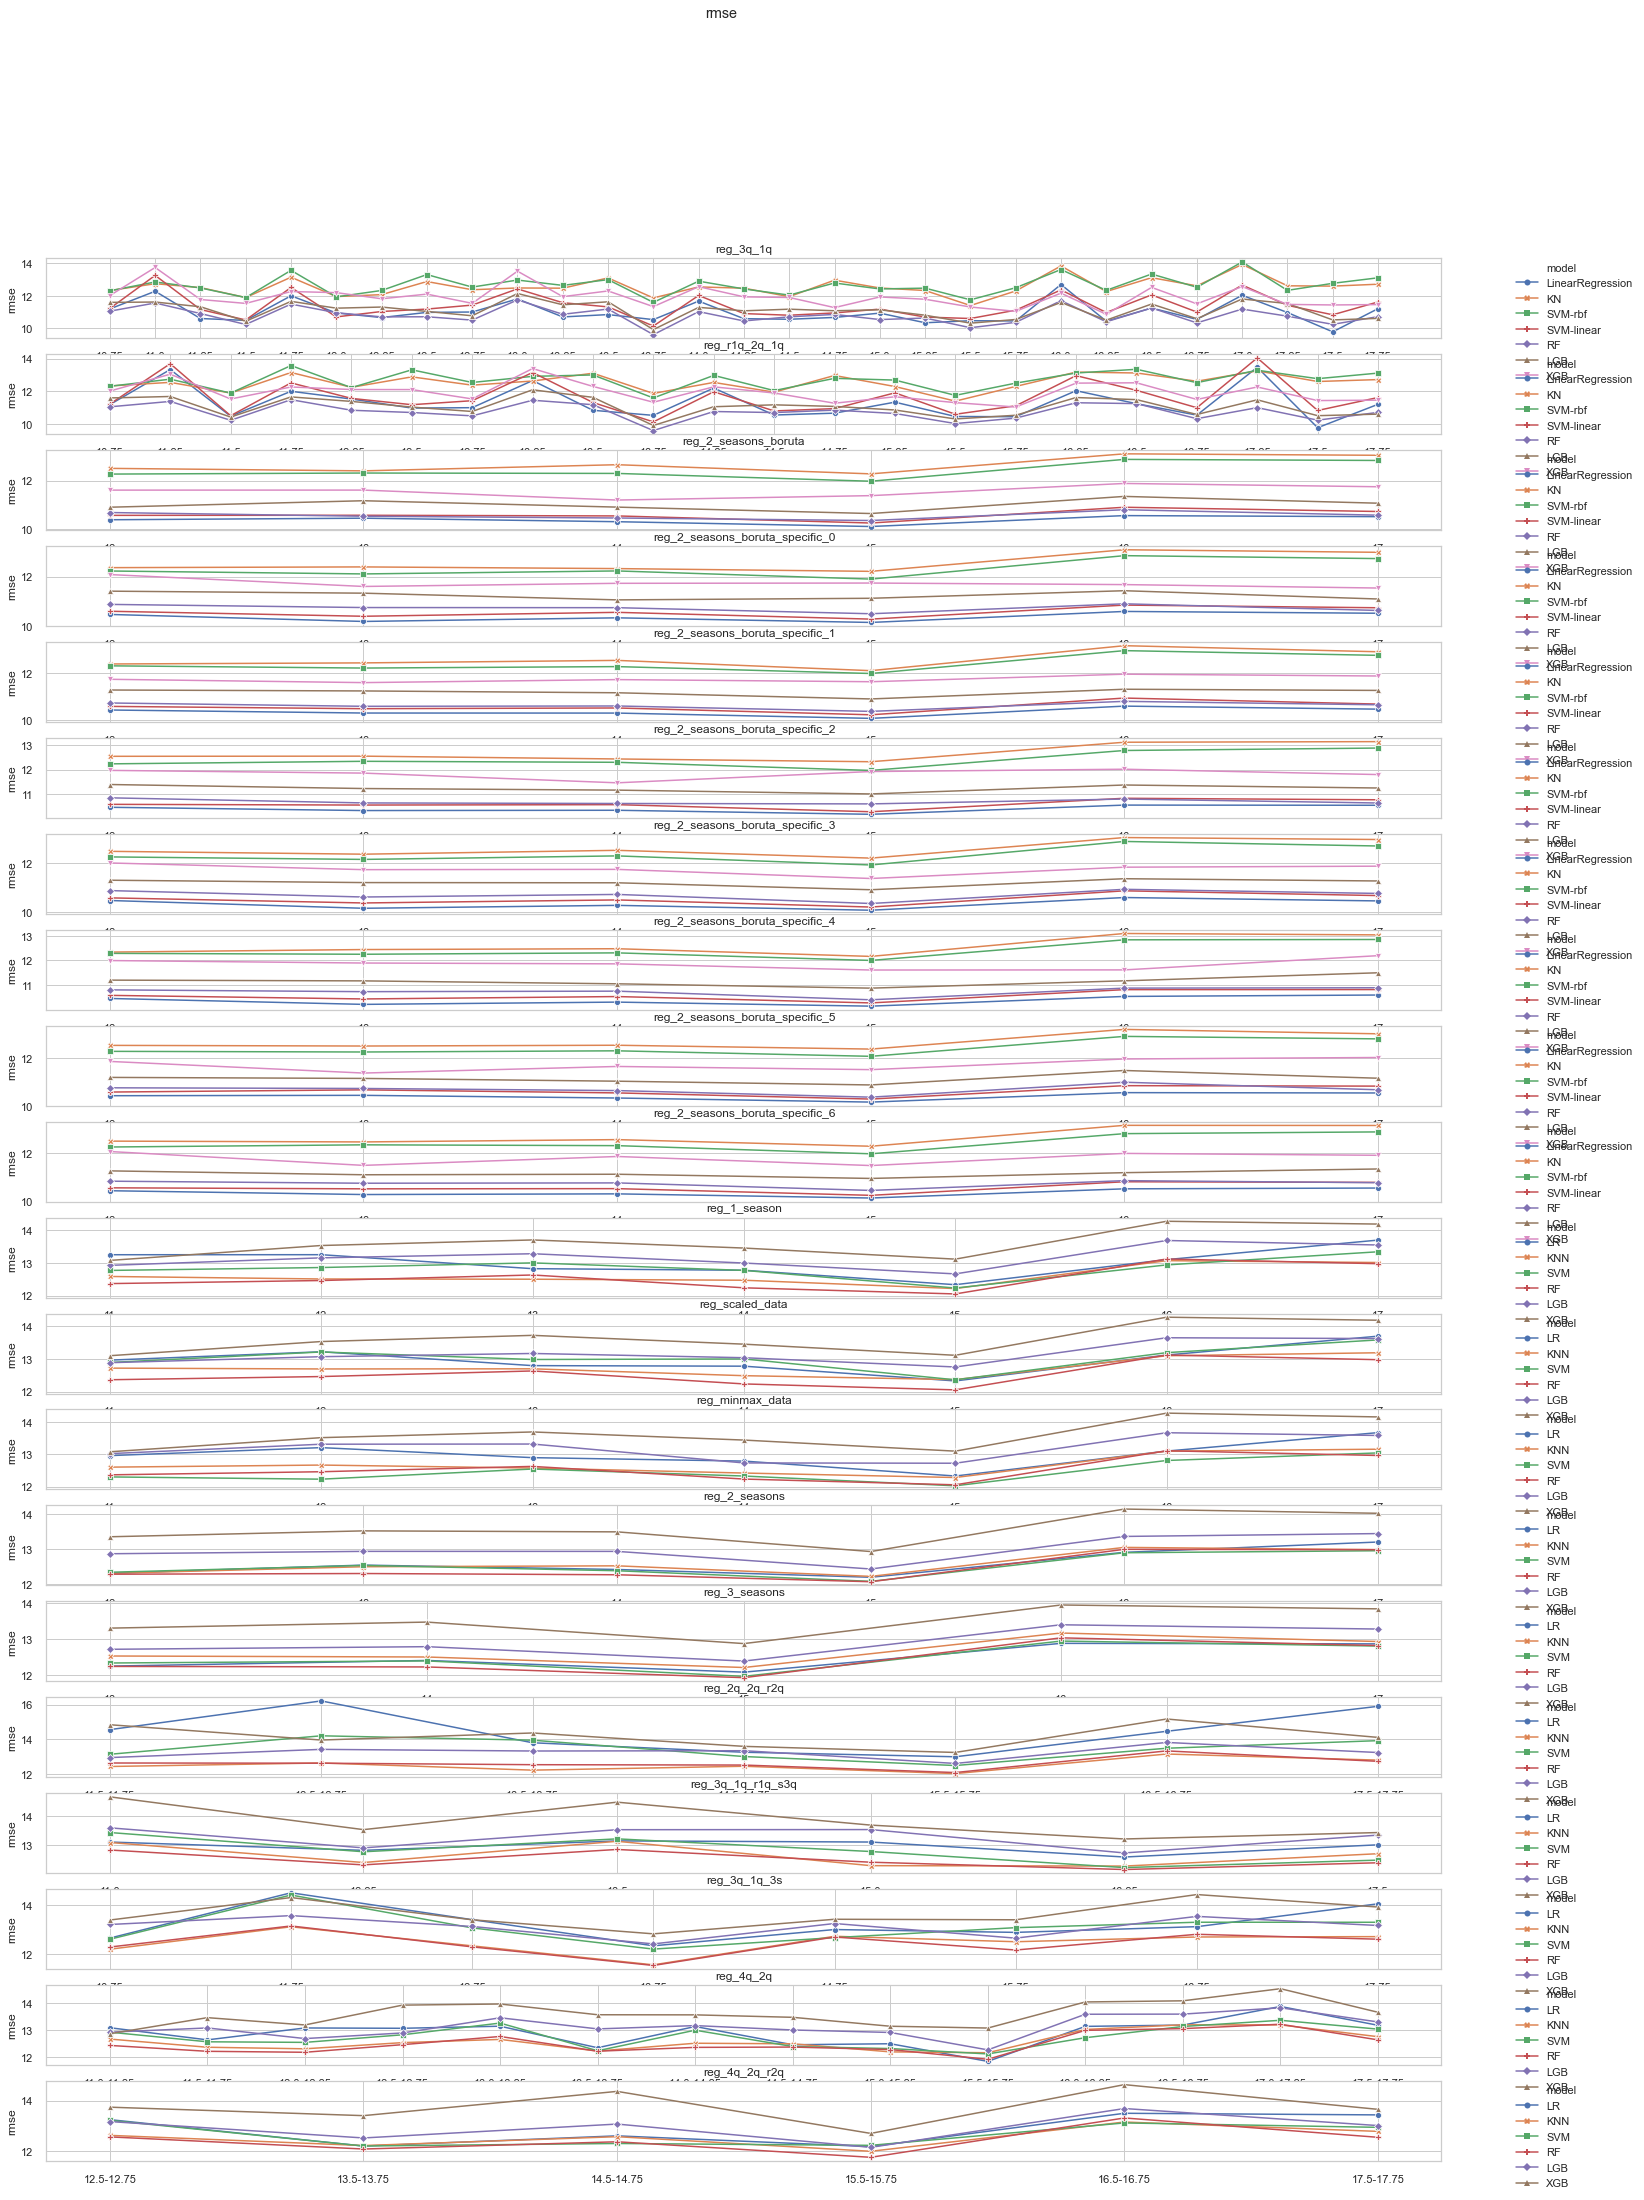

In [76]:
utils.plot_to_compare_experiments(
    results_total,
    metric="rmse",
    figsize=(25, 35),
    use_pointplot=True
)